In [33]:
import pandas as pd
from pandas import DataFrame
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import os
import re
import plotly.express as px
import matplotlib.pyplot as plt

In [49]:
import plotly.io as pio

pio.renderers.default = 'browser'

In [23]:
files = os.listdir('pops3')

files_data = [file for file in files if re.search(r'Data', file)]

files_index = [file for file in files if re.search(r'Ids', file)]

# Ordena arquivos por timestep (numero pós o "t")
files_data = sorted(files_data, key=lambda x: int(x.split('t')[1].split()[0]))
files_index = sorted(files_index, key=lambda x: int(x.split('t')[1].split()[0]))

In [44]:
df = pd.read_csv(f'pops3/{files_data[0]}', sep='\t', header=None)

C:\Users\gugub\AppData\Local\Temp\ipykernel_9580\2290259354.py:9: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



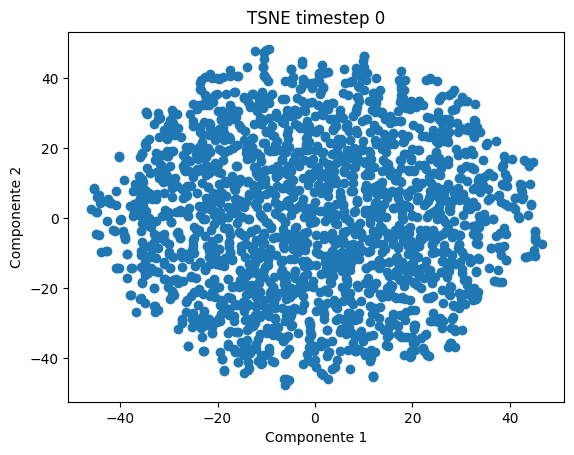

<Figure size 1200x600 with 0 Axes>

In [51]:
def plot_tsne(data: DataFrame, timestep: int, species=None):
    tsne = TSNE(n_components=2, random_state=42)
    data_tsne = tsne.fit_transform(data)
    df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])

    # Faz o plot junto
    fig, ax = plt.subplots()
    fig = plt.figure(figsize=(12, 6))
    scatter = ax.scatter(df_tsne['x'], df_tsne['y'], c=species, cmap='viridis', label=species)
    
    ax.set_title(f'TSNE timestep {timestep}')
    ax.set_xlabel('Componente 1')
    ax.set_ylabel('Componente 2')
    
    if species is not None:
        legend1 = ax.legend(*scatter.legend_elements(), title="Species")
        ax.add_artist(legend1)
    
    plt.show()

    fig = px.scatter(df_tsne, x='x', y='y', title=f'TSNE timestep {timestep}', labels={'x': 'TSNE 1', 'y': 'TSNE 2'}, color=species)
    fig.show()

plot_tsne(df, 0)